# Assignment 3, Ennakoivat menetelmät – AVTEK 2025
Sairasvakuutusmaksut – k-means clustering


Ryhmän jäsenet:
Anniina Mäkinen, Jyri Männikkö, Niina Pietilä

Vastuut:
**Niina** - Testaus eri k-arvoilla, Elbow- methodi, samankaltaisuusanalyysi, visualisointi

**Jyri** - Eri k-means laskujen testailu, algorytmi, tulkinta

**Anniina** - Datasetin valinta, esikäsittely, k- means, käyttötarkoitukset

## 1 – K-means algoritmiin tutustuminen ja testaus

### 1.1 Datasetti – Sairasvakuutusmaksut

Valitsimme sairasvakuutusmaksu -datasetin, koska se sisältää useita numeraalisia muuttujia sekä sen lisäksi se sisältää myös muutaman kategorisen muuttujan.

Tavoitteenamme on ryhmitellä datasetissä olevat henkilöt ryhmiin henkilöiden kanssa, jonka kanssa he jakavat samankaltaisia ominaisuuksia. 

Datasetti sisältää yhteensä 1338 henkilön vastausta ja sisältää seuraavat muuttujat:
- age – henkilön ikä vuosina (numeerinen)
- sex – sukupuoli (male, female)
- bmi – painoindeksi, joka kuvaa painon ja pituuden suhdetta (numeerinen)
- children – huollettavien/lasten lukumäärä (numeerinen)
- smoker – tupakoiko henkilö (yes/no)
- region – asuinalue Yhdysvalloissa (northeast, northwest, southeast, southwest)
- charges – vuosittaiset terveysvakuutusmaksut USD (numeerinen)


In [1]:
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv("insurance.csv")
df_clean = df.dropna()

print("Datasetin tiedot:", df.shape)
print("\nDatasetin ensimmäiset rivit:")
display(df.head())

print("\nYhteenveto:")
display(df.describe(include="all"))

Datasetin tiedot: (1338, 7)

Datasetin ensimmäiset rivit:


,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0.0,yes,southwest,16884.92400
1,18.0,male,33.770,1.0,no,southeast,1725.55230
2,28.0,male,33.000,3.0,no,southeast,4449.46200
3,33.0,male,22.705,0.0,no,northwest,21984.47061
4,32.0,male,28.880,0.0,no,northwest,3866.85520



Yhteenveto:


,age,sex,bmi,children,smoker,region,charges
count,1337.000000,1338,1337.000000,1337.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.219147,NaN,30.664589,1.095737,NaN,NaN,13270.422265
std,14.048217,NaN,6.100313,1.205571,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.290000,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.700000,2.000000,NaN,NaN,16639.912515


### 1.2 K-keskiarvon laskeminen
Askeleet:
1. Muunnan kategoriset sarakkeet (`sex`, `smoker`, `region`) numeerisiksi one-hot-enkoodauksella.
2. Standardisoin kaikki piirteet (keskiarvo 0, keskihajonta 1).
3. Sovitan k-means -mallin käyttäen `k = 3`.
4. Liitän klusterit alkuperäiseen dataan ja tarkastelen keskimääräisiä arvoja klusterien sisällä.


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

df = df.dropna()

df_encoded = pd.get_dummies(df, columns=["sex", "smoker", "region"], drop_first=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)

# k-mean, k = 3
k=3
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_scaled)
clusters = kmeans.labels_


df_with_clusters = df.copy()
df_with_clusters["cluster_3"] = clusters

# Keskiarvot
cluster_means = df_with_clusters.groupby("cluster_3")[["age", "bmi", "children", "charges"]].mean()
print("Keskiarvot klustereissa (k=3):")
display(cluster_means)

Keskiarvot klustereissa (k=3):


,age,bmi,children,charges
cluster_3,,,,
0,38.432234,30.714451,1.117216,32060.887039
1,39.626109,29.687567,1.101394,8555.787626
2,38.673993,33.442418,1.065934,8032.216309


### Visualisointi

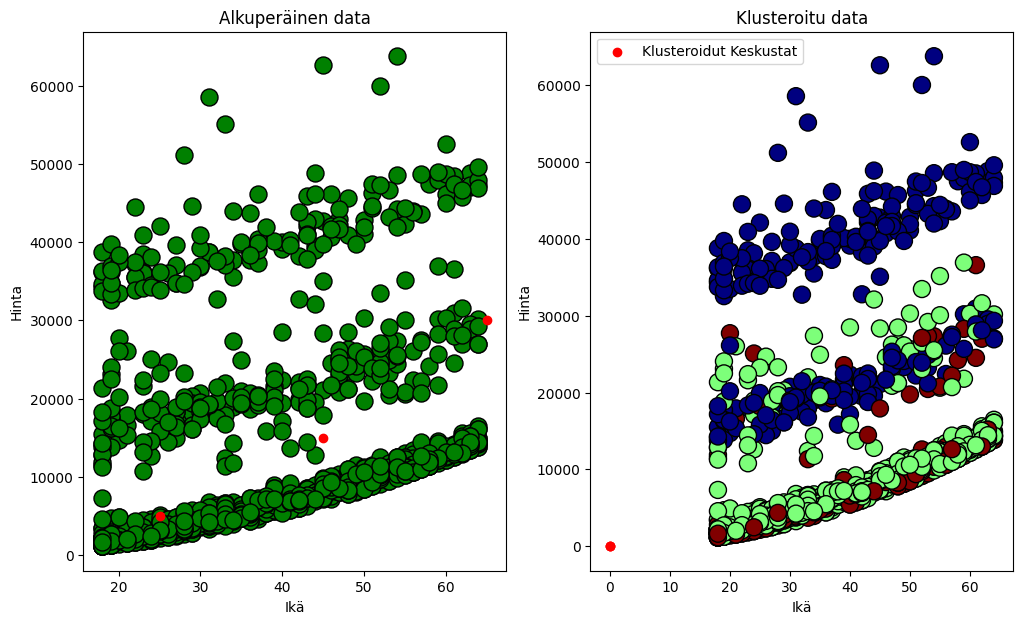

In [4]:
X_plot = df_with_clusters[["age", "charges"]].values

init_centers = np.array([
    [25, 5000],
    [45, 15000],
    [65, 30000]
])

def plot_my_cluster(kmeans_object, init_centers, X_data):
    fig, axes = plt.subplots(1, 2, figsize=(12, 7))
    
    # alkuperänen data
    axes[0].scatter(X_data[:, 0], X_data[:, 1], c='g', edgecolor='k', s=150)
    axes[0].set_xlabel('Ikä')
    axes[0].set_ylabel('Hinta')
    axes[0].set_title('Alkuperäinen data')
    axes[0].scatter(init_centers[:,0], init_centers[:,1], c='r', label='Initial Centers')
    
    # klusteroitu data
    axes[1].scatter(X_data[:, 0], X_data[:, 1], c=kmeans_object.labels_, cmap='jet', edgecolor='k', s=150)
    axes[1].set_xlabel('Ikä')
    axes[1].set_ylabel('Hinta')
    axes[1].set_title('Klusteroitu data')
    axes[1].scatter(kmeans_object.cluster_centers_[:,0], kmeans_object.cluster_centers_[:,1], c='r', label='Klusteroidut Keskustat')
    
    plt.legend()
    plt.show()


plot_my_cluster(kmeans, init_centers, X_plot)

### 1.3 Käyttötarkoituksia k-means -algoritmille


**Esimerkki 1: Asiakassegmentointi markkinoinnissa**  
- K-meanssin avulla yritykset voi ryhmitellä asiakkaitaan asiakasrekisteristä ostohistorian perusteella kohdemarkkinointia varten, kuten esim. asiakkaat jotka arvostavat tarjouksia, uskolliset kanta-asiakkaat, satunnaiset asiakkaat yms. 

**Esimerkki 2: Musiikintoisto palveluiden suositukset**  
- K-means -algorytmiä voidaan hyödyntää musiikintoistopalveluissa suositellakseen asiakkaille samanlaisia kappaleita tykätyjen kappaleiden tempon, genren ja sanoituksien perusteella


## Part 2

### 2.1 K-means algorytmin testaukset

In [5]:
from collections import Counter
from sklearn.cluster import KMeans

results = []
inspect_features = ["charges"]

for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    inertia = kmeans.inertia_
    sizes = Counter(labels)
    

    temp = df.copy().reset_index(drop=True)
    temp["cluster"] = labels

    mean_charges = temp.groupby("cluster")["charges"].mean().values
    
    results.append((k, inertia, sizes, mean_charges))


for k, inertia, sizes, mean_charges in results:
    print(f"\n=== k = {k} ===")
    print("Inertia:", round(inertia, 2))
    print("Cluster sizes:", dict(sizes))
    print("Mean charges in clusters:", [round(x, 2) for x in mean_charges])


=== k = 2 ===
Inertia: 9831.68
Cluster sizes: {np.int32(0): 273, np.int32(1): 1062}
Mean charges in clusters: [np.float64(32060.89), np.float64(8421.2)]

=== k = 3 ===
Inertia: 8479.47
Cluster sizes: {np.int32(0): 273, np.int32(2): 273, np.int32(1): 789}
Mean charges in clusters: [np.float64(32060.89), np.float64(8555.79), np.float64(8032.22)]

=== k = 4 ===
Inertia: 7265.23
Cluster sizes: {np.int32(0): 271, np.int32(2): 273, np.int32(3): 268, np.int32(1): 523}
Mean charges in clusters: [np.float64(32182.62), np.float64(8594.39), np.float64(8032.22), np.float64(8532.78)]

=== k = 5 ===
Inertia: 6546.64
Cluster sizes: {np.int32(1): 270, np.int32(3): 273, np.int32(2): 268, np.int32(4): 257, np.int32(0): 267}
Mean charges in clusters: [np.float64(8064.29), np.float64(32250.54), np.float64(8532.78), np.float64(8032.22), np.float64(9165.53)]

=== k = 6 ===
Inertia: 6136.96
Cluster sizes: {np.int32(4): 138, np.int32(5): 273, np.int32(1): 266, np.int32(2): 257, np.int32(3): 135, np.int32(0):

#### Tulosten tulkinta 

**K=2** 
 - Kun k=2 Klustereiden välinen eroavaisuus on suuri ja selkeä ero matalien ja korkeiden maksujen välillä. Yhdessä klusterissa on erittäin korkeat maksut (n. 32k), toisessa on selkeästi taas matalammat maksut (n. 8k)

**K=3** 
 - Kun k=3 korkeat maksut sisältävä klusteri pysyy yhä erillään, mutta matalampien maksujen klusteri jakautuu kahteen tarkempaan maksu -ryhmään. Tämän avulla saamme tarkempaa dataa matalammista maksuista.

**K=4** 
- Myös kun k=4, pysyy yhä korkeat maksut erillään ja matalammat maksut jakautuvat kolmeen ryhmään. Sama kuin aikaisemman k -arvon kohdalla, jakautumine tapahtuu matalampien maksujen kohdalla tarkempiin ryhmiin.

**K=5** 
- Kun k=5 alkaa klusterit jakautumaan hieman tasaisemmin, vaikkakin korkeat maksut yhä pysyy omana klusterinaan. Kuitenkin alhaisemmat maksut alkavat jakautumaan tasaisemmin 8k -9k välillä useampaan ryhmään.

**K=6**
- Kun k=6, jakautuvat myös suuremmat maksut eri klustereihin. On yksi todella korkeilla maksuilla oleva klusteri (n. 42k), yksi keskikorkeat maksut sisältävä klusteri (n. 22k) ja useampia keski-/ matalia maksuja sisältäviä klustereita jotka jakautuvat 8k -9k välille.

Inertian arvoja tarkkailemalla huomaamme, että se laskee aina k:n kasvaessa. Kuitenkin k=4 jälkeen lasku hidastuu huomattavasti aiempaan verrattuna, josta voimme päätellä että sen jälkeen klustereiden lisäämisestä ei ole enään yhtä paljon hyötyä.


### 2.2 Elbow -methodin käyttö

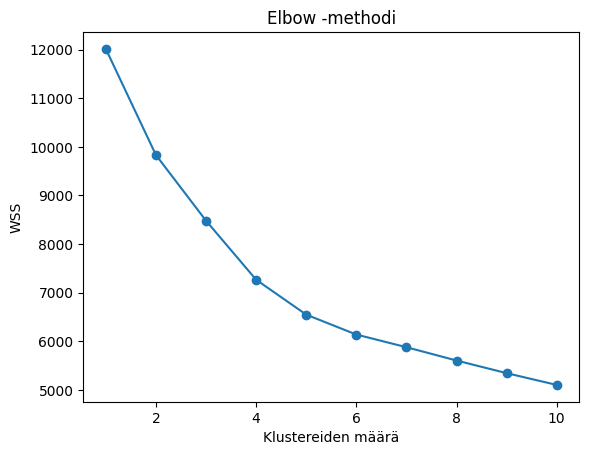

In [6]:
from sklearn.cluster import KMeans
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker="o")
plt.title('Elbow -methodi')
plt.xlabel('Klustereiden määrä')
plt.ylabel('WSS') 
plt.show()

#### Elbow- methodin tulkinta
Elbow- methodista syntyneestä kuviosta voidaan tulkita, että inertia pienenee nopeammin kun k:n arvo on 1-4 välillä. Kuitenkin tämän jälkeen inertian pieneneminen hidastuu, jolloinka uusien kllustereiden lisääminen ei tee suurta eroa tuloksille. 

Kuviossa "kyynerpää" asettuu k=4 kohdalle, joka tukee aiemman testauksemme tulosta. 

### 2.3 K-means algortihmin eri asetusten kokeilu

Lopuksi testataan joitakin k-means -algoritmin eri asetuksia käyttäen esimerkkinä klusterimäärää k = 4. Tarkasteltavia asetuksia ovat:
- `init` – alustusmenetelmä (`"k-means++"` vs. `"random"`)
- `n_init` – montako kertaa algoritmi ajetaan eri aloituspisteillä
- `max_iter` – sallittu maksimimäärä iteraatioita per ajo

Vertaillaan seuraavia asetuksia:
1. Oletusasetukset (k-means++-alustus).
2. Satunnainen alustus (`init="random"`).
3. Suurempi `n_init` (20 ajoa eri aloituspisteillä).
4. Pienempi `max_iter` (50 iteraatiota).

Jokaisesta kokoonpanosta tallennetaan inertia-arvo ja toteutuneiden iteraatioiden määrä.

In [7]:
# 2.3 Testing various k-means options

# 1) Oletusasetukset
km_default = KMeans(n_clusters=4, random_state=42)
km_default.fit(X_scaled)
print("Oletus (k-means++): inertia =", round(km_default.inertia_, 2),
        ", iteraatiot =", km_default.n_iter_)

# 2) Satunnainen alustus
km_random = KMeans(n_clusters=4, init="random", random_state=42)
km_random.fit(X_scaled)
print("Satunnainen init: inertia =", round(km_random.inertia_, 2),
        ", iteraatiot =", km_random.n_iter_)

# 3) Suurempi n_init
km_ninit = KMeans(n_clusters=4, n_init=20, random_state=42)
km_ninit.fit(X_scaled)
print("Suurempi n_init: inertia =", round(km_ninit.inertia_, 2),
        ", iteraatiot =", km_ninit.n_iter_)

# 4) Pienempi max_iter
km_maxiter = KMeans(n_clusters=4, max_iter=50, random_state=42)
km_maxiter.fit(X_scaled)
print("Pienempi max_iter: inertia =", round(km_maxiter.inertia_, 2),
        ", iteraatiot =", km_maxiter.n_iter_)


Oletus (k-means++): inertia = 7265.23 , iteraatiot = 9
Satunnainen init: inertia = 7261.93 , iteraatiot = 9
Suurempi n_init: inertia = 7261.93 , iteraatiot = 7
Pienempi max_iter: inertia = 7265.23 , iteraatiot = 9


#### Asetuskokeilujen tulkinta
Tulostaulukosta voidaan tehdä seuraavia johtopäätöksiä:
- **Oletusasetukset (k-means++)** antavat jo valmiiksi hyvän ratkaisun, jossa inertia on pieni ja iteraatioiden määrä kohtuullinen.
- **Satunnainen alustus** voi johtaa hieman huonompaan inertiaan ja joskus suurempaan iteraatiomäärään, koska lähtöpisteet eivät ole yhtä hyviä.
- **Suuremman `n_init`-arvon** käyttö parantaa ratkaisun luotettavuutta, koska paras tulos valitaan useista eri ajokerroista. Tämä voi hieman pienentää inertiaa, mutta lisää laskenta-aikaa.
- **Pienempi `max_iter`** voi joissain tapauksissa estää algoritmia konvergoitumasta täysin, mikä näkyy hieman suurempana inertia-arvona. Tässä aineistossa vaikutus ei kuitenkaan ole kovin suuri.

Kokonaisuutena kokeet osoittavat, että k-means++-alustus oletusasetuksilla on hyvä lähtökohta, mutta `n_init`-arvon kasvattaminen voi parantaa tulosta erityisesti monimutkaisemmilla aineistoilla.